# Merging classification results

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import evaluate
import merge
import load

In [3]:
# Load evaluation data
test_columns = ['returnQuantity', 'articleID', 'productGroup', 'customerID', 'voucherID']
test_predictions = merge.merged_predictions(test=True, keep_columns=test_columns)
test_train = evaluate.test_complement(test_predictions)

# Load classification data
class_columns = ['articleID', 'productGroup', 'customerID', 'voucherID']
class_predictions = merge.merged_predictions(keep_columns=class_columns)
class_train = load.orders_train()

## Confidences
### Imputation

Approximately 4% of predictions by team C have unknown confidences, making imputation necessary before merge approaches based on confidence can be applied. Because of this relatively small number, I propose to impute missing values using the mean confidence of Team C. The mean showed stable behavior across all splits in the test and prediction data.

### Comparison
Using approaches based on confidence implies comparison across classifiers. This is complicated by the different distributions of confidence, as depicted in the figure below.

In [7]:
# Violinplot for class data and evaluation data
def confidence_plot(class_data, evaluation_data):  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    ax1.set_title('Classification')
    ax = sns.violinplot(data=class_data['confidence'], ax=ax1)
    ax2.set_title('Evaluation')
    ax = sns.violinplot(data=evaluation_data['confidence'], ax=ax2)

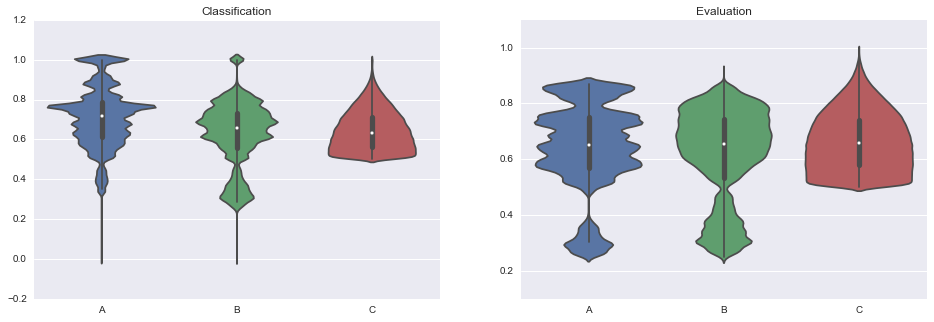

In [8]:
# Violinplot for original data
confidence_plot(class_predictions, test_predictions)

Instead of using the actual values, I propose to redefine the confidence in standard-deviations distance from the mean.

$$ conf_{i,c} = 1 + \frac{conf_{i,c} - \mu_c}{\sigma_c} * \frac{1}{max(conf_c)}$$

with $conf_{i,c}$ being the confidence of classification $c$ in row $i$. To confine the range in [-1, 1], the confidences for each classifier are divided by its maximum confidence. The center of the distributions is then moved to 1, making the confidences applicable as multiplier weights. NaN values are filled with ones (then representing the mean).

This approach centers the central tendencies at 1 and decreases the differences in the ranges by setting the standard deviations to 1.

The figure below shows the distributions of the imputed predictions.

In [4]:
# Impute zeroes and convert confidenes to std-distances
class_imputed = merge.impute_confidence(class_predictions)
test_imputed = merge.impute_confidence(test_predictions)

# Violinplot for imputed data
confidence_plot(class_imputed, test_imputed)

NameError: name 'confidence_plot' is not defined

## Approach 1: Naive Majority Vote
For each row, take the most common prediction. As we have 3 teams there is always a majority.

The naive majority vote assumes that each classifier is equally good and always equally confident. It uses relies on the least assumptions about performance evaluation and confidence comparability.

In [ ]:
class_naive = merge.naive_majority_vote(class_imputed)
test_naive = merge.naive_majority_vote(test_imputed)

This approach can be evaluated on the test set; the result is shown in the figure below.

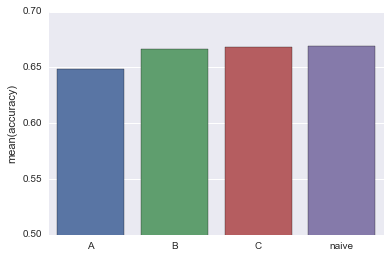

In [80]:
# Calculate mean accuracies
naive_mean_accuracies = evaluate.mean_accuracies(test_naive)

# Barplot
ax = sns.barplot(x=mean_accuracies.index, y=naive_mean_accuracies['accuracy'])
lim = ax.set_ylim([0.5, 0.7])

The values are 64.85%, 66.66%, 66.86% and 66.89% in that order. The approach seems to yield a very small improvement compared to the best performing single team classification.

However, the new classification seems to resolve most of the arguments between the teams (cf. figure below). The naive merge seems to agree with teams A and C (under 1% distinct rows), while disagreeing mostly with team B (11%).

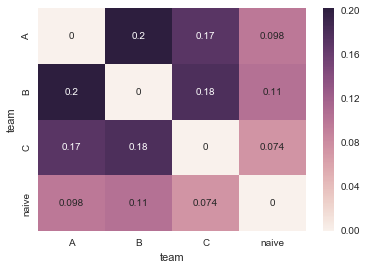

In [85]:
# Calculate difference for each combination
naive_differences = evaluate.distinct_predictions(class_naive)

# Heatmap
ax = sns.heatmap(naive_differences, annot=True)

The differences between the naive merge and team B go along with the differences team B had with other teams, the top four splits not present in the test set.

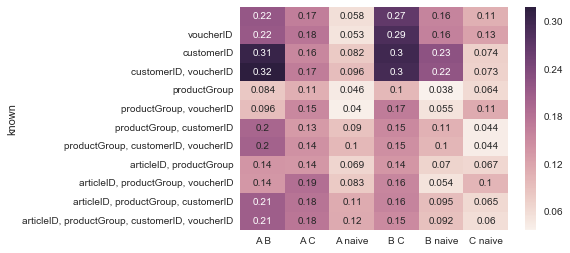

In [86]:
# Calculate differences across splits
naive_split_differences = evaluate.distinct_split_predictions(class_train, class_naive)

# Heatmap
ax = sns.heatmap(naive_split_differences, annot=True)

## Approach 2: Weighted Majority Vote

We use the following formula for the final $prediction_i$, with $i$ being the row index. In it, each $prediction_{c,i}$ of classifier $c$ is weighted.

$$
row_i =
\dfrac
    {\sum_{c \in C}
        prediction_{c,i}
        \cdot weight_{c,i}}
    {\sum_{c \in C} weight_{c,i}}
$$

The $weight_{c,i}$ takes into account the condfidence of $c$ in row $i$, the mean confidence of $c$ over all rows, the overall accuracy of $c$ and the mean accuracy of all classifiers.

$$
weight_{c,i} = \dfrac{confidence_{c,i}}{confidence_{c,\varnothing}} \cdot \bigg(\dfrac{accuracy_c}{accuracy_\varnothing}\bigg)^2
$$

The confidences returned by the classifiers are, as such, not comparable to each other. They differ in meaning and in range. To counteract and to avoid favoring classifiers that are generally -maybe mistakenly- confident, we take the confidence compared to the classifier's mean confidence.

The accuracy, we believe, is the best predictor of a classifier's performance in the target set. We take this information from a test set that each group used to evaluate their classifier. The test set is a 70/30 split of the training data. We compare the accuracy to the mean accuracy of all classifiers. As the difference tends to be big in information, but small in extent, the ratio is squared.

In [15]:
df = class_imputed.copy()

In [27]:
df[['prediction', 'confidence']].ix[5:10]

prediction              confidence  \
                                               A     B      C          A   
orderID  articleID colorCode sizeCode                                      
a1744179 i1001147  1001      42             True  True  False   0.899279   
         i1001151  3082      42             True  True  False   0.886893   
         i1001160  1108      42             True  True   True   0.609405   
         i1001461  2493      42             True  True  False   0.609405   
         i1001480  1001      42             True  True  False   0.609405   

                                                           
                                              B         C  
orderID  articleID colorCode sizeCode                      
a1744179 i1001147  1001      42        0.427345  0.858307  
         i1001151  3082      42        0.538328  0.951594  
         i1001160  1108      42        0.491853  0.817023  
         i1001461  2493      42        0.504776  0.756678  
         i1001480  1001      42        0.511578  0.656294

In [53]:
class_imputed.ix[:10]

confidence                      \
                                               A         B         C   
orderID  articleID colorCode sizeCode                                  
a1744178 i1002632  3097      I          0.947832  1.121262  0.588841   
         i1003278  1097      40         1.028453  1.157223  0.786403   
         i1003279  1114      40         1.028453  1.142398  0.588841   
                   1116      40         1.028453  1.142398  0.927519   
                   1117      40         1.028453  1.142398  0.871073   
a1744179 i1001147  1001      42         0.899279  0.427345  0.858307   
         i1001151  3082      42         0.886893  0.538328  0.951594   
         i1001160  1108      42         0.609405  0.491853  0.817023   
         i1001461  2493      42         0.609405  0.504776  0.756678   
         i1001480  1001      42         0.609405  0.511578  0.656294   

                                      prediction                original  \
                                               A      B      C articleID   
orderID  articleID colorCode sizeCode                                      
a1744178 i1002632  3097      I             False  False  False  i1002632   
         i1003278  1097      40            False  False  False  i1003278   
         i1003279  1114      40            False  False  False  i1003279   
                   1116      40            False  False  False  i1003279   
                   1117      40            False  False  False  i1003279   
a1744179 i1001147  1001      42             True   True  False  i1001147   
         i1001151  3082      42             True   True  False  i1001151   
         i1001160  1108      42             True   True   True  i1001160   
         i1001461  2493      42             True   True  False  i1001461   
         i1001480  1001      42             True   True  False  i1001480   

                                                                         
                                      productGroup customerID voucherID  
orderID  articleID colorCode sizeCode                                    
a1744178 i1002632  3097      I                17.0   c1062117  v1000415  
         i1003278  1097      40                3.0   c1062117  v1000415  
         i1003279  1114      40                3.0   c1062117  v1000415  
                   1116      40                3.0   c1062117  v1000415  
                   1117      40                3.0   c1062117  v1000415  
a1744179 i1001147  1001      42                4.0   c1319458         0  
         i1001151  3082      42                4.0   c1319458         0  
         i1001160  1108      42                4.0   c1319458         0  
         i1001461  2493      42                6.0   c1319458         0  
         i1001480  1001      42                6.0   c1319458         0

In [5]:
weights = pd.Series([1,1,1], index=class_imputed['prediction'].columns)
%time rows = merge.weighted_majority_vote(class_imputed.ix[:10], weights)
rows

CPU times: user 37.7 ms, sys: 35.7 ms, total: 73.4 ms
Wall time: 76.4 ms


confidence                      \
                                               A         B         C   
orderID  articleID colorCode sizeCode                                  
a1744178 i1002632  3097      I          0.947832  1.121262  0.588841   
         i1003278  1097      40         1.028453  1.157223  0.786403   
         i1003279  1114      40         1.028453  1.142398  0.588841   
                   1116      40         1.028453  1.142398  0.927519   
                   1117      40         1.028453  1.142398  0.871073   
a1744179 i1001147  1001      42         0.899279  0.427345  0.858307   
         i1001151  3082      42         0.886893  0.538328  0.951594   
         i1001160  1108      42         0.609405  0.491853  0.817023   
         i1001461  2493      42         0.609405  0.504776  0.756678   
         i1001480  1001      42         0.609405  0.511578  0.656294   

                                       original                          \
                                      articleID customerID productGroup   
orderID  articleID colorCode sizeCode                                     
a1744178 i1002632  3097      I         i1002632   c1062117         17.0   
         i1003278  1097      40        i1003278   c1062117          3.0   
         i1003279  1114      40        i1003279   c1062117          3.0   
                   1116      40        i1003279   c1062117          3.0   
                   1117      40        i1003279   c1062117          3.0   
a1744179 i1001147  1001      42        i1001147   c1319458          4.0   
         i1001151  3082      42        i1001151   c1319458          4.0   
         i1001160  1108      42        i1001160   c1319458          4.0   
         i1001461  2493      42        i1001461   c1319458          6.0   
         i1001480  1001      42        i1001480   c1319458          6.0   

                                                prediction                \
                                      voucherID          A      B      C   
orderID  articleID colorCode sizeCode                                      
a1744178 i1002632  3097      I         v1000415      False  False  False   
         i1003278  1097      40        v1000415      False  False  False   
         i1003279  1114      40        v1000415      False  False  False   
                   1116      40        v1000415      False  False  False   
                   1117      40        v1000415      False  False  False   
a1744179 i1001147  1001      42               0       True   True  False   
         i1001151  3082      42               0       True   True  False   
         i1001160  1108      42               0       True   True   True   
         i1001461  2493      42               0       True   True  False   
         i1001480  1001      42               0       True   True  False   

                                                 
                                       weighted  
orderID  articleID colorCode sizeCode            
a1744178 i1002632  3097      I         0.000000  
         i1003278  1097      40        0.000000  
         i1003279  1114      40        0.000000  
                   1116      40        0.000000  
                   1117      40        0.000000  
a1744179 i1001147  1001      42        0.607170  
         i1001151  3082      42        0.599635  
         i1001160  1108      42        1.000000  
         i1001461  2493      42        0.595545  
         i1001480  1001      42        0.630731

In [ ]:
weights = pd.Series([1,1,1], index=class_imputed['prediction'].columns)
%time merge.weighted_majority_vote(class_imputed, weights, round=False)

In [56]:
weights = pd.Series([1,1,1], index=class_imputed['prediction'].columns)

In [59]:
test_weighted_confidence = merge.weighted_majority_vote(test_imputed, weights)

In [60]:
class_weighted_confidence = merge.weighted_majority_vote(class_imputed, weights)

KeyboardInterrupt: 

In [ ]:
weights = evaluate.mean_accuracies(test_predictions)['accuracy']

In [ ]:
test_weighted_accuracy = merge.weighted_majority_vote(test_imputed, weights)

In [ ]:
class_weighted_accuracy = merge.weighted_majority_vote(class_imputed, weights)

## Approach 3: Avoiding disagreement

In [88]:
### Approach 4: Weighted Majority Vote based on plits